## 加载图像

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

im = Image.open(r'handwritting.png').convert('L')  # 转换为灰度图像
im_arr = np.array(im)

### 确定阈值

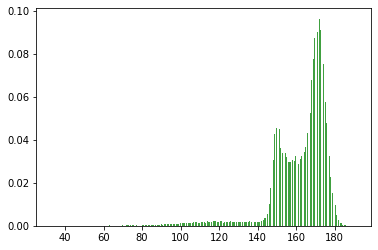

In [2]:
plt.figure("hist")
arr = im_arr.flatten()
n, bins, patches = plt.hist(arr, bins=256, density=1, facecolor='green', alpha=0.75)
plt.show()
# 阈值在143左右

### 去除背景灰度 

In [3]:
def convert_to_bw(im, threshold):
    im = im.point(lambda x: 255 if x > threshold else 0)  # 阈值处理
    im = im.convert('1')  # 黑白二值图像
    return im
im = convert_to_bw(im, 143)
im.show()

### 将小数字方块分割出来

In [4]:
img_dirname = 'data/img/'
def split(im):
    assert im.mode=='1'
    w, h = im.size
    xs = [0, 31, 65, 91, 122, 150, 182, 211, 242, 271, w]
    ys = [0, 47, 93, 137, 185, 232, h]
    for i, x in enumerate(xs):
        if i + 1 >= len(xs):
            break
        for j, y in enumerate(ys):
            if j + 1 >= len(ys): 
                break
            box = (x, y, xs[i+1], ys[j+1])  # 一个字符所在图像的位置
            t = im.crop(box).copy()  # 将字符挖出来
            t.save(img_dirname + str((i+1)%10) + '_' + str(j) + '.bmp')
split(im)

实际情况中如果字写的太大
`t = t.resize((32,32), Image.ANTIALIAS)` 调整到32*32

### 标准化
提取出的每个字符图像，大小不一，字符在小图像中位置布局中
希望每个图像大小都是32*32， 且字符的上下、左右边距一样

In [5]:
img_32_32_dirname = 'data/img_32_32/'
def standardizing_to_32_32(im, ii, jj):
    w, h = im.size
    xrow, ycol = [], []
    for i in range(w):
        for j in range(h):
            pixel = im.getpixel((i,j))
            if(pixel<1):
                xrow.append(i)
                ycol.append(j)
                # 字符的长度、宽度
                xLength, yLength = max(xrow)-min(xrow)+1, max(ycol)-min(ycol)+1
                # 定义左、上、右、下的坐标
                box = (min(xrow), min(ycol), max(xrow)+1, max(ycol)+1)
                # 一个矩形区域的拷贝
                t = im.crop(box).copy()
                # 居中
                xStart, yStart = (32-xLength)//2, (32-yLength)//2
                bg = Image.new('RGB',(32,32),'white')
                # 将一张图粘贴到另一张图像上
                bg.paste(t, (xStart,yStart))
                bg.save(img_32_32_dirname + str(ii) + '_' + str(jj) + "_32_32.bmp")
            
for i in range(10):
    for j in range(6):
        im = Image.open(img_dirname + str(i) + '_' + str(j) + '.bmp')
        standardizing_to_32_32(im, i, j)

## 数字特征表示
将32*32的小图像分割成256个 2*2的范围，统计每个2*2的小方框中，像素值为0的个 数，由此将每个字符表达为256个数字组成的向量

In [6]:
def featureExtract(im):
    im = im.convert("1")
    y = np.array([0,1])
    features = []
    for j in range(16):
        x = np.array([0,1])
        for i in range(16):
            box = (x[0],y[0],x[1]+1,y[1]+1)  # 2*2开区间
            t = im.crop(box).copy()
            count = 0.0
            for ii in range(2):
                for jj in range(2):
                    pixel = t.getpixel((ii,jj))
                    if(pixel < 1):
                        count += 1.0
            features.append(count)
            x += 2  # 整个矩阵向右平移
        y += 2
    return features

netTrainDataInput = []  # 存储输入数据 X
netTrainDataOutput = [] # 存储输出点真值 Y
for i in range(10):
    outNode = [0.0]*10
    outNode[i] = 1.0  # 训练集函数的真值，每种模式对应的位置数字为1
    for j in range(6):
        im = Image.open(img_32_32_dirname + str(i) + '_' + str(j) + '_32_32.bmp')
        f = featureExtract(im)
        netTrainDataInput.append(f)
        netTrainDataOutput.append(outNode)
X = np.array(netTrainDataInput)
y = np.array(netTrainDataOutput)

## 神经网络
- 输入层：256向量
- 输出层：正交编码
- 中间层：64（注意过拟合）

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# 标准画数据
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)
# 交叉验证
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100,),alpha=1e-5,random_state=1,max_iter=8000)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print('预测得分: ', score)
yhat = clf.predict(X_test)
print('预测值: ', yhat)
print('真值', y_test)

预测得分:  0.5
预测值:  [[0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]]
真值 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
